# Import Libraries 

In [87]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.4
Scikit-Learn 1.0.2
GPU is available


In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix

from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel
from skimage.feature import canny


import itertools
import os
import cv2
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings 
warnings.simplefilter(action= 'ignore', category=FutureWarning)
%matplotlib inline

# Loading Images

In [2]:
train_path = '../data/dataset_unbalanced/train/'
test_path = '../data/dataset_unbalanced/val/'

In [3]:
folders = glob.glob(train_path + '*')

train_list = pd.DataFrame(glob.glob(train_path + '*')).rename(columns = {0: 'name'})
# generate ordinal categories for y

train_list['class_name'] = train_list.name.apply(lambda x: x.split("\\")[1])

classes = train_list['class_name'].unique().tolist()
print(f'Number of classes: {len(classes)}')

Number of classes: 22


In [4]:
for num,name in enumerate(classes):
    print(num,name)

0 Baby_Chyesim
1 Bean
2 Bitter_Gourd
3 Bottle_Gourd
4 Brinjal
5 Broccoli
6 Cabbage
7 Capsicum
8 Carrot
9 Cauliflower
10 Celery
11 Coriander
12 Cucumber
13 Daun_Sup
14 Kailan
15 Kangkong
16 Parsley
17 Potato
18 Pumpkin
19 Radish
20 Sharp_Spinach
21 Tomato


# EDA 

## Check image sizes


In [22]:
# creating dataframe to hold in image sizes 
# taking just first picture. 

data = []
labels = []
for vege in classes:
    dir = "../data/dataset_unbalanced/train/" + vege + "/*.*"
    image=tf.keras.preprocessing.image.load_img(glob.glob(dir)[0], color_mode='rgb')
    image=np.array(image)
    image = image / 255
    data.append(image.shape)
    labels.append(vege)

In [23]:
pd.DataFrame(data,labels).rename(columns = {0: 'Length', 1: 'Width', 2: 'Color'})

,Length,Width,Color
Baby_Chyesim,224,224,3
Bean,224,224,3
Bitter_Gourd,224,224,3
Bottle_Gourd,224,224,3
Brinjal,224,224,3
Broccoli,224,224,3
Cabbage,224,224,3
Capsicum,224,224,3
Carrot,224,224,3
Cauliflower,224,224,3


We can observe that there all of the photos are sized the same. 

## Check number of images per class

In this section, we will want to understand if having imbalanced dataset affectes the model accuracy, whether or not probabilities for each class gets more defined over the rest of the classes. 


In [24]:
train_batches = ImageDataGenerator(
        rescale = 1./225,
    ).flow_from_directory(directory = train_path, target_size = (224,224), class_mode = 'categorical', batch_size = 32)

test_batches = ImageDataGenerator(
        rescale = 1./225,
    ).flow_from_directory(directory = test_path, target_size = (224,224), class_mode = 'categorical',batch_size = 32)

Found 52090 images belonging to 22 classes.
Found 10443 images belonging to 22 classes.


In [25]:
# create function to make dataframe
def make_df(batch):
    make_list = []
    for files in batch.filenames:
        make_list.append(files)
    df = pd.DataFrame(make_list).rename(columns = {0: 'Filename'})
    df['cat'] = df['Filename'].apply(lambda x: x.split("\\")[0])
    return df

In [26]:
# create function to plot images per class 
def plot_images_per_class(df, header):
    plt.figure(figsize=(15,7))
    df['cat'].value_counts().plot.bar()

    font = {'weight': 'normal','size': 16,}
    plt.title(f'Number of images per class in {header} dataset', fontdict= font)
    plt.tick_params(axis='both', labelsize=14)
    plt.xlabel('Class', fontdict= font)
    plt.ylabel('No. of images', fontdict = font)

    plt.show()

In [27]:
# get dataframe for train and test set 

df_train = make_df(train_batches)
df_test = make_df(test_batches)

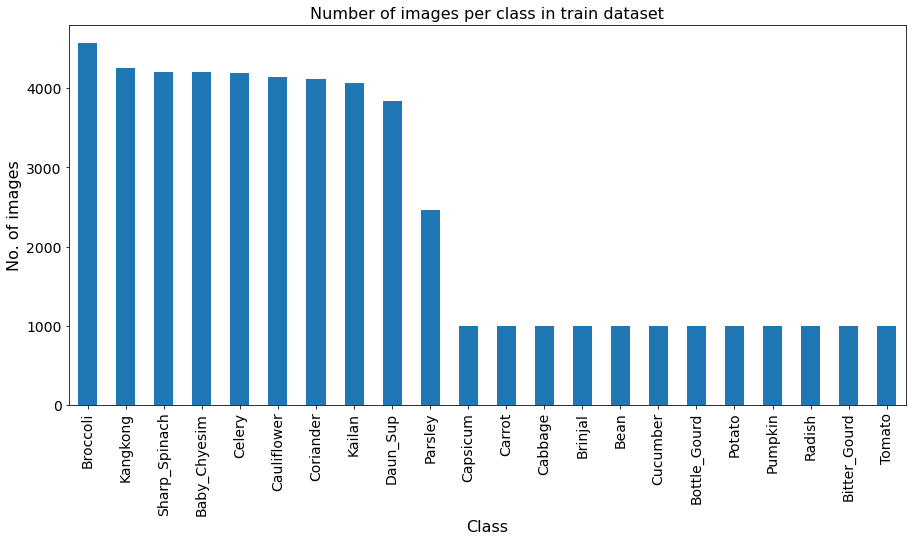

In [28]:
# create train dataset plot 
plot_images_per_class(df_train, 'train')

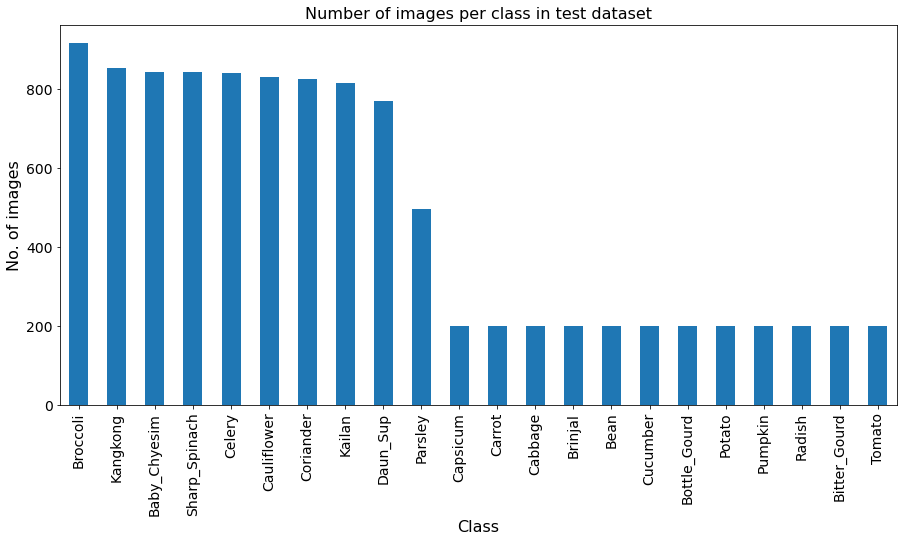

In [29]:
# create test dataset plot 
plot_images_per_class(df_test, 'test')

There are at least 10 classes with more than 2000 images per class as compared to the rest of the classes. 

The reason behind having huge images for some of these classes, was to train the model better in picking up the difference between two classes that are difficult to distinguish ie. Kailan Vs Chyesim, Coriander Vs Parsley

Ratio between train and test data are constant across all classes.

In [30]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize = (30,30))
    axes = axes.flatten()

    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


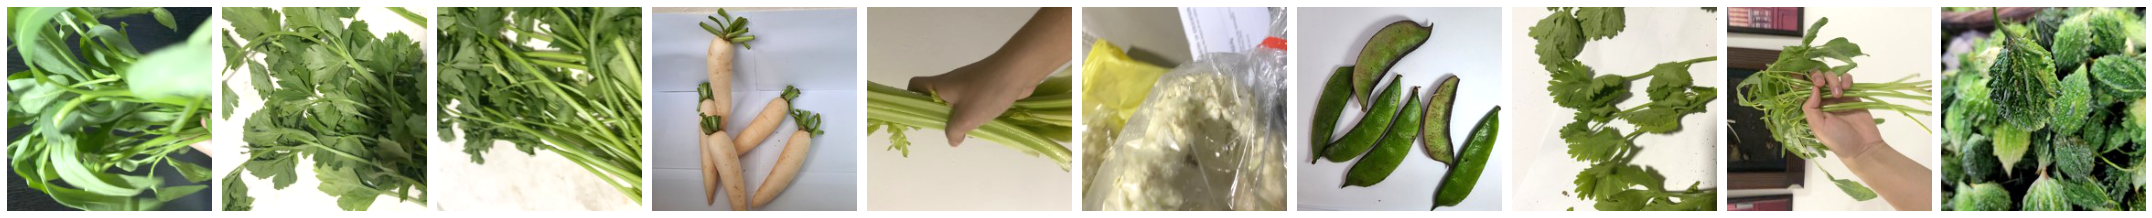

In [31]:
imgs, labels = next(train_batches)
plotImages(imgs)

In [32]:
imgs.shape

(32, 224, 224, 3)

Images in batches of 32 when using ImageDataGenerator. Since we will be dealing with colours, the number of layers X width and height will be massive to train the model on. 

Original photos are provided in RGB. For the nature of this project, having colour would be useful to differentiate vegetables like broccoli from cauliflower. Next we will look into some feature extraction methods as to how to better train the model later. 

# Feature engineering - Feature extraction

This section helps to understand better of what our problem statement needs in order to generate good predictions 

In [33]:
def give_col_image(path):
    img = cv2.imread(path)
    col_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    return col_img

In [34]:
def give_gray_image(col_img):
    gray_img = cv2.cvtColor(col_img, cv2.COLOR_BGR2GRAY)
    
    return gray_img

In [35]:
def give_gaussian_image(gray_img):
    gaussian_img = gaussian(gray_img, sigma=4)
    
    return gaussian_img

In [36]:
def give_gabor_image(gray_img):

    ksize = 5
    sigma = 0.5
    theta = 1*np.pi/4
    lamda = 1*np.pi/4
    gamma = 0.8
    phi = 0

    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
    gabor_img = cv2.filter2D(gray_img, cv2.CV_8UC3, gabor_kernel)
    
    return gabor_img

In [37]:
def give_canny_image(gray_img):
    # canny_img = cv2.Canny(gray_img, 80, 180)
    canny_img = canny(gray_img, sigma=0.9)
    
    return canny_img

In [38]:
# use imagedatagenerator to create batches with preprocessing input inside

train_path = '../data/dataset_unbalanced/train/'
test_path = '../data/dataset_unbalanced/val/'

vgg_preprocessed = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(directory = train_path, target_size = (224,224), class_mode = 'categorical', batch_size = 32)

mobilenet_preprocessed = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
).flow_from_directory(directory = train_path, target_size = (224,224), class_mode = 'categorical', batch_size = 32)

Found 52090 images belonging to 22 classes.
Found 52090 images belonging to 22 classes.


In [39]:
# getting one batch of vgg preprocessed images 
 
imgs, labels = next(vgg_preprocessed)
imgs_mobilenet, labels_mobilenet = next(mobilenet_preprocessed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

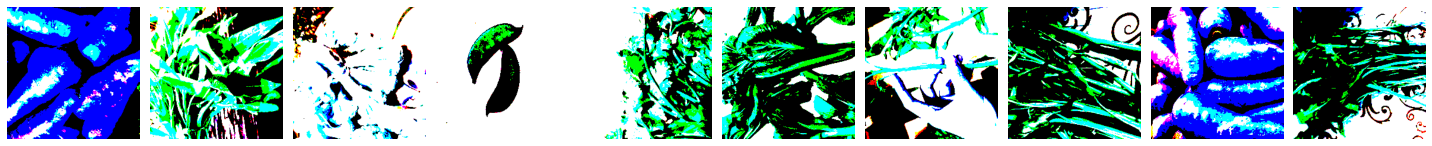

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

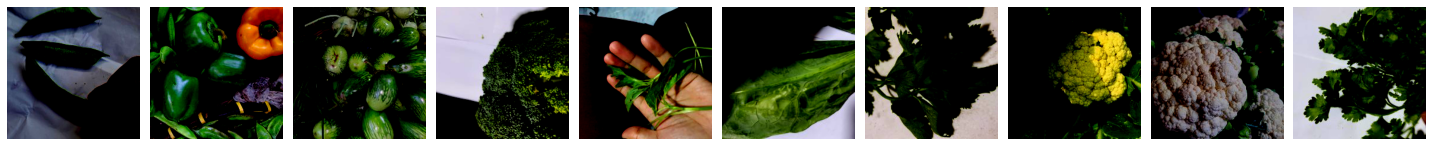

In [41]:
# show series of images by vgg preprocessing 
plotImages(imgs);

# show series of images by mobilenet preprocessing 
plotImages(imgs_mobilenet);

C:\Users\Admin\.conda\envs\dsi27tf\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


Text(0.105, 0.15, 'Canny Edges')

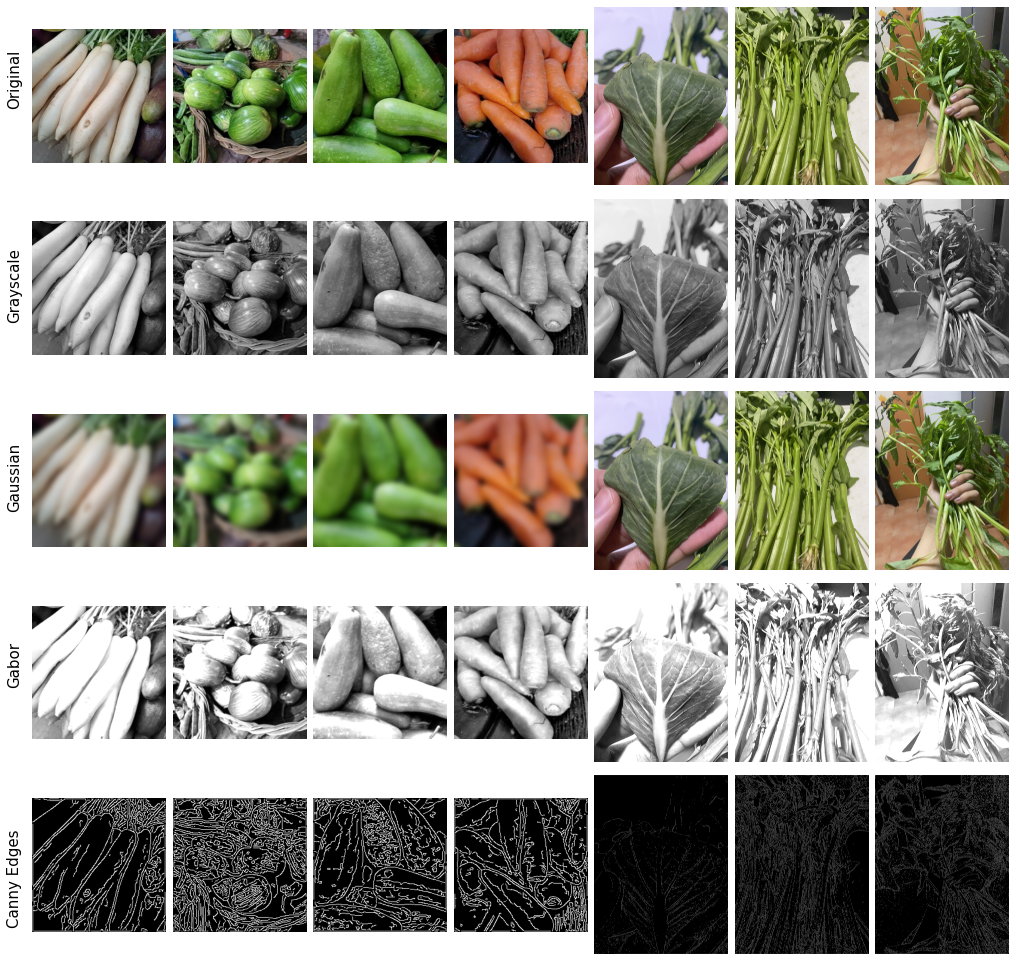

In [42]:
# getting images from sample images data and plot preprocessing inputs in array horizontally 

sample_images_path = '../data/sample_images/'

sample_images = os.listdir(sample_images_path)

n_images = len(sample_images)

fig, ax = plt.subplots(nrows=5, ncols=n_images, figsize=(n_images*2.5, 17.5))
plt.gray()

ax= ax.ravel()

for i, img in enumerate(sample_images):
    
    img_path = os.path.join(sample_images_path, img)
    
    col_img = give_col_image(img_path)
    ax[i].imshow(col_img)
    ax[i].axis('off')

    gray_img = give_gray_image(col_img)
    ax[i+(n_images*1)].imshow(gray_img)
    ax[i+(n_images*1)].axis('off')
    
    gaussian_img = give_gaussian_image(col_img)
    ax[i+(n_images*2)].imshow(gaussian_img)
    ax[i+(n_images*2)].axis('off')

  
    gabor_img = give_gabor_image(gray_img)
    ax[i+(n_images*3)].imshow(gabor_img)
    ax[i+(n_images*3)].axis('off')
    
    canny_img = give_canny_image(gray_img)
    ax[i+(n_images*4)].imshow(canny_img)
    ax[i+(n_images*4)].axis('off')
    
plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.figtext(x=0.105, y=0.80, s="Original", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.63, s="Grayscale", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.48, s="Gaussian", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.34, s="Gabor", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.15, s="Canny Edges", fontsize=15, rotation=90)


**Key observations and takeaways**

- We need `coloured images` to train the model to accurately differentiate between vegetables of similar shape but different color. We can opt for either the `original` or the `mobilenetv2` preprocessing technique. 
- `Blurring` can be used to introduce more variability in the model to better predict on unseen data. The reason why we are especially using this, is because we will need to consider the fact that the camera we are using might be blurred on occasions. I will want the model to be able to still make accurate predictions with it as well. 
- `Grayscale` cannot use as we cant differentiate carrot and radish.
- `Edges` cannot be used too as some vegetables have similar shapes. 